In [2]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import os 
import joblib

from skimage.util import img_as_ubyte
from skimage.transform import resize
from skimage.future import predict_segmenter, fit_segmenter
from skimage.feature import multiscale_basic_features
from sklearn.ensemble import RandomForestClassifier
from PIL import Image

%matplotlib widget

## Random Forest Model Testing

In [27]:

model = joblib.load('wheat_model.joblib')

img_dir = '/home/iantsang/Images/Wheat/Raw/'
mask_dir = '/home/iantsang/Images/Wheat/Masks/'

train_img = iio.imread(os.path.join(img_dir, 'pic10_shrunk.png'))
train_mask = iio.imread(os.path.join(mask_dir, 'pic10_shrunk_Simple Segmentation.png'))

newmask = train_mask.copy()

newmask[train_mask == 0] = 1
newmask[train_mask == 1] = 2
newmask[train_mask == 2] = 3

train_mask = newmask

def features_func(img):
    return multiscale_basic_features(img,
                                     intensity=True,
                                     edges=True,
                                     texture=True,
                                     sigma_min=1,
                                     sigma_max=4,
                                     channel_axis=-1)


def train(mask, features, model):

    train_labels = mask.ravel()
    train_features = features[mask > 0]

    model.fit(train_features, train_labels)

    return model

clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)

train_features = features_func(train_img)

clf = train(train_mask, train_features, clf)

# joblib.dump(clf, 'wheat_model_v2.joblib')

# print(train_mask.shape)
# print(train_mask[train_mask>0].ravel())
# print(train_mask.ravel())

# print(train_features.shape)
# print(train_features[train_mask].shape)
# print(train_features.shape)


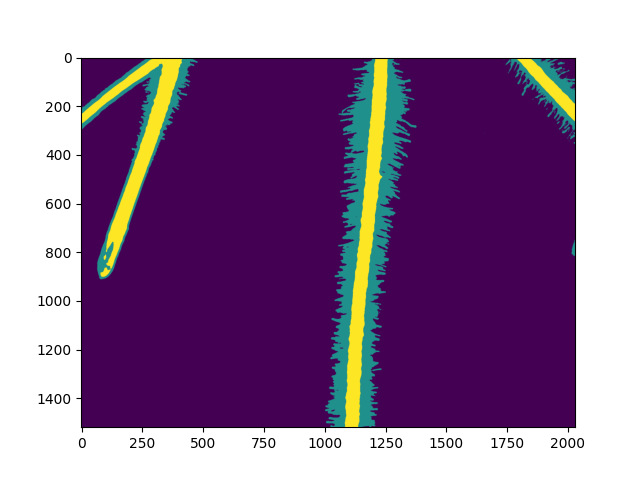

In [29]:
test = iio.imread('test.png')

fig, ax = plt.subplots()
ax.imshow(test)

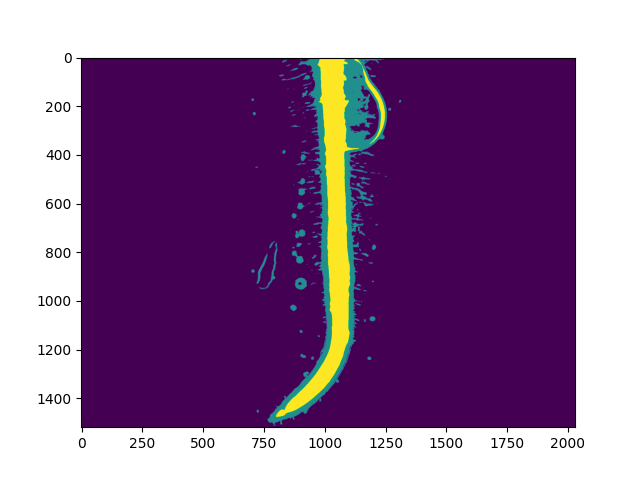

In [ ]:
def predict(features, model):
    ft_shape = features.shape
    if features.ndim > 2:
        features = features.reshape((-1, ft_shape[-1]))
    
    predicted = model.predict(features)

    return predicted.reshape(ft_shape[:-1])


model = joblib.load('wheat_model.joblib')
test_img = iio.imread('/home/iantsang/Images/Brachypodium/1-stitch-crop/20190503_zoom2_WT_plant1_Stitch_crop_edited.png')
features = features_func(test_img)

result = predict(features, model)

fig, ax = plt.subplots()
ax.imshow(result)


In [68]:
folder = '/home/iantsang/Images/Arabidopsis/2-stitch-crop/'
image = iio.imread(os.path.join(folder, '20181205_Col0_Mock_R03_Stitched_crop.png'))
#1520 2028 3
test = iio.imread(os.path.join(folder, '20181205_Col0_Mock_R03_Stitched_crop_edited.png'))
# image = Image.open('/home/iantsang/Images/Arabidopsis/2-stitch-crop/20181205_Col0_Mock_R03_Stitched_crop.png')
print(image.shape)


(4960, 1272, 4)


In [67]:
old_h, old_w, old_c = image.shape
print(f'Original dtype: {image.dtype}')
target_h, target_w, target_c = (1520, 2028, 3)

resize_factor = old_h / target_h

if old_h != target_h : # only shrink image if original image is taller than 1520 px
    resized_img = resize(image, (old_h // resize_factor, old_w // resize_factor), anti_aliasing=True)
    resized_h, resized_w, resized_c = resized_img.shape
    print(f'Resized dtype: {resized_img.dtype}')

if resized_w < target_w: # if resized with smaller than 2028, pad
    pad_amount = (target_w - resized_w) // 2
    resized_img = np.pad(resized_img, ((0,0),(pad_amount, pad_amount+1), (0,0)), mode='edge')
    print(f'Padded dtype: {resized_img.dtype}')

if resized_img.shape[2] != target_c:
    resized_img = resized_img[:,:,:3] # get rid of alpha channel if it exists
    print(f'3-channel dtype: {resized_img.dtype}')

resized_img = img_as_ubyte(resized_img)

assert resized_img.shape[0:3] == (target_h, target_w, target_c)

iio.imwrite('test_resized.png', resized_img)

Original dtype: uint8
Resized dtype: float64
Padded dtype: float64
3-channel dtype: float64
